In [111]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import datetime

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
import tensorflow.keras as keras

# Data wrangling

In [63]:
df = pd.read_csv('Wildfire.csv')
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'fire_name','disc_date_final','cont_date_final','cont_clean_date','putout_time'])
df['disc_clean_date'] = pd.to_datetime(df['disc_clean_date'], format='%m/%d/%Y')
df.columns

Index(['fire_size', 'fire_size_class', 'stat_cause_descr', 'latitude',
       'longitude', 'state', 'disc_clean_date', 'discovery_month',
       'disc_date_pre', 'disc_pre_year', 'disc_pre_month', 'wstation_usaf',
       'dstation_m', 'wstation_wban', 'wstation_byear', 'wstation_eyear',
       'Vegetation', 'fire_mag', 'weather_file', 'Temp_pre_30', 'Temp_pre_15',
       'Temp_pre_7', 'Temp_cont', 'Wind_pre_30', 'Wind_pre_15', 'Wind_pre_7',
       'Wind_cont', 'Hum_pre_30', 'Hum_pre_15', 'Hum_pre_7', 'Hum_cont',
       'Prec_pre_30', 'Prec_pre_15', 'Prec_pre_7', 'Prec_cont', 'remoteness'],
      dtype='object')

In [64]:
### Dealing with missing data
print(len(df))

# drop columns where weather file is missing
index = df[df['weather_file'] == 'File Not Found'].index
df.drop(index, inplace = True)
print(len(df))

# Weather data has a lot of 0 values some of which may be missing values
# So here we mark '0' values in weather columns as Na (to see how many there are)
subset = ['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont']
df[subset] = df[subset].replace({0:np.nan, '0':np.nan})
subset_neg1 = ['Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont']
df[subset_neg1] = df[subset_neg1].replace({-1:np.nan})

# Drop observations where all weather columns are 0
df = df.dropna(how='all',
                    subset=['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont'])
print(len(df))
# This leaves us with 38,689 observations to work with (originally we had 50,000)

# fill pre columns temp wind and humidity with mean values
subset_fill_mean = ['Temp_pre_30','Temp_pre_15','Temp_pre_7', 'Wind_pre_30','Wind_pre_15','Wind_pre_7', 'Hum_pre_30', 'Hum_pre_15','Hum_pre_7']
df[subset_fill_mean] = df[subset_fill_mean].fillna(df[subset_fill_mean].mean())

# Fill nas of current based on mean values from previous days
df['Temp_cont'] = df.apply(
    lambda row: (row['Temp_pre_7']+row['Temp_pre_15']+row['Temp_pre_30'])/3 if np.isnan(row['Temp_cont']) else row['Temp_cont'],
    axis=1)

df['Wind_cont'] = df.apply(
    lambda row: (row['Wind_pre_7']+row['Wind_pre_15']+row['Wind_pre_30'])/3 if np.isnan(row['Wind_cont']) else row['Wind_cont'],
    axis=1)

df['Hum_cont'] = df.apply(
    lambda row: (row['Hum_pre_7']+row['Hum_pre_15']+row['Hum_pre_30'])/3 if np.isnan(row['Hum_cont']) else row['Hum_cont'],
    axis=1)

55367
41132
38689


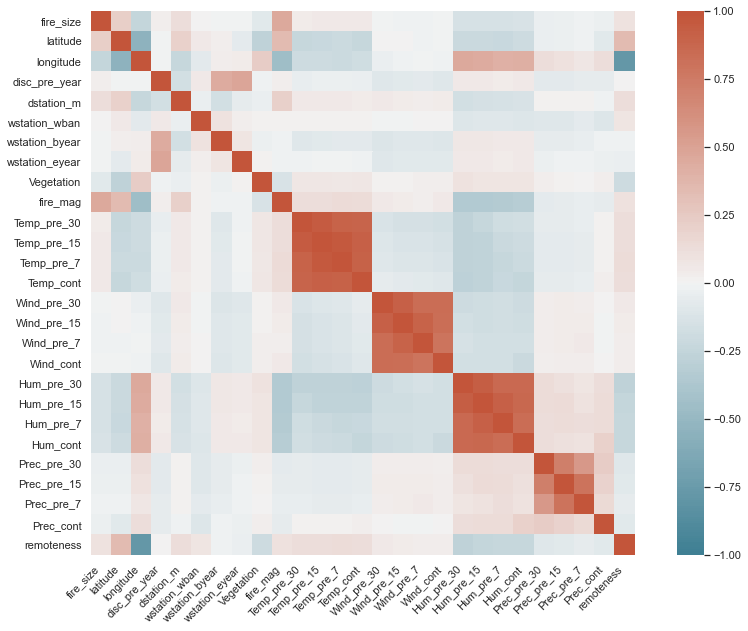

In [65]:
df_numerics_only = df.select_dtypes(include=np.number)

corr = df_numerics_only.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
sns.set(rc={'figure.figsize':(15,10)})

In [66]:
#one hot encoding vegetation
df['Vegetation'] = df['Vegetation'].astype('category')
df['Vegetation'] = df['stat_cause_descr'].astype('category')

df = pd.get_dummies(df,prefix=['Vegetation'], columns = ['Vegetation'], drop_first=True)
#df = pd.get_dummies(df,prefix=['Cause'], columns = ['stat_cause_descr'], drop_first=True)

df.head()

fire_size fire_size_class   stat_cause_descr   latitude   longitude state  \
0       10.0               C  Missing/Undefined  18.105072  -66.753044    PR   
1        3.0               B              Arson  35.038330  -87.610000    TN   
2       60.0               C              Arson  34.947800  -88.722500    MS   
3        1.0               B     Debris Burning  39.641400 -119.308300    NV   
6        5.2               B     Debris Burning  31.316978  -83.393649    GA   

  disc_clean_date discovery_month disc_date_pre  disc_pre_year  ...  \
0      2007-02-11             Feb     1/12/2007           2007  ...   
1      2006-12-11             Dec    11/11/2006           2006  ...   
2      2004-02-29             Feb     1/30/2004           2004  ...   
3      2005-06-06             Jun      5/7/2005           2005  ...   
6      2009-01-10             Jan    12/11/2008           2008  ...   

  Prec_pre_15 Prec_pre_7  Prec_cont  remoteness  Vegetation_4  Vegetation_9  \
0         0.0        0.0        0.0    0.017923             0             0   
1         8.4        0.0       86.8    0.184355             0             0   
2        42.2       18.1      124.5    0.194544             0             0   
3         7.2        0.0        0.0    0.487447             0             0   
6         0.0        0.0        0.0    0.148904             0             0   

   Vegetation_12 Vegetation_14  Vegetation_15  Vegetation_16  
0              1             0              0              0  
1              0             0              1              0  
2              0             0              0              1  
3              0             0              0              0  
6              1             0              0              0  

[5 rows x 41 columns]

In [108]:
# selecting features and target variables
X = df[['Vegetation_4','Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont']]
y = df['fire_size'] + df['fire_mag']

X_norm = (X-X.min())/(X.max()-X.min())
y_norm = (y-y.min())/(y.max()-y.min())

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
X = df[['Vegetation_4','Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont']]
trans = MinMaxScaler()
X_trans = trans.fit_transform(X)
X_trans = pd.DataFrame(X_trans)
X = X_trans

y = df['fire_size'] + df['fire_mag']
Y_trans= trans.fit_transform(y)
Y_trans=pd.DataFrame(Y_trans)
Y_trans = Y_trans.rename(columns={0: "Intensity"})
y = Y_trans

ValueError: Expected 2D array, got 1D array instead:
array=[1.0000e+01 3.0000e+00 6.0000e+01 ... 6.2890e+03 5.7020e+03 7.6067e+04].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

## Modelling

In [109]:
# Deccision trees
# Random forest
# PCA
# neural network
# XGboost

In [96]:
# Deccision trees
dectr = DecisionTreeRegressor(random_state=0)
dectr.fit(X_train, y_train)
#cross_val_score(dectr, X_train, y_train, cv=10).mean()

DecisionTreeRegressor(random_state=0)

In [97]:
dectr.score(X_test,y_test)

-1.0901620346217706

In [88]:
predictions = dectr.predict(X_test)
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('R Squared:', metrics.r2_score(y_test, predictions))

Mean Absolute Error: 0.013963071801547858
R Squared: -2.5974984550903084


In [100]:
gr_boost = GradientBoostingRegressor()
gr_boost.fit(X_train, y_train)

GradientBoostingRegressor()

In [101]:
#cross_val_score(gr_boost, X_train, y_train, cv=10).mean()

In [102]:
predictions = gr_boost.predict(X_test)
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('R Squared:', metrics.r2_score(y_test, predictions))

Mean Absolute Error: 3217.5570105102097
R Squared: 0.059830426676689696


In [125]:
# Random Forest Regressor 
rf_reg = RandomForestRegressor(n_estimators = 250, max_depth=8)

# fit the regressor with x and y data
rf_reg.fit(X_train, y_train)  

RandomForestRegressor(max_depth=8, n_estimators=250)

In [126]:
predictions = rf_reg.predict(X_test)
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('R Squared:', metrics.r2_score(y_test, predictions))

Mean Absolute Error: 3117.0065977846475
R Squared: 0.10499067589228062


In [127]:
cross_val_score(rf_reg, X_test, y_test, cv=10).mean()

-0.02069997384727401

In [116]:
rfreg.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [124]:
search_grid={'n_estimators':[10,50,100,250],'max_depth':[2,4,5,6,7,8]}
rfreg = RandomForestRegressor()
search=GridSearchCV(estimator=gbr,param_grid=search_grid,scoring='r2',n_jobs=1,cv=5)
search.fit(X_train, y_train)
print(search.best_score_)
print(search.best_params_)

0.15844188723246325
{'max_depth': 8, 'n_estimators': 250}


In [83]:
feature_importances = pd.DataFrame(rf_reg.feature_importances_,
    index = X_train.columns,columns=['importance']).sort_values('importance',ascending=False)
feature_importances

importance
latitude         0.186960
Hum_cont         0.109403
Temp_pre_15      0.072151
Temp_cont        0.070898
Wind_pre_30      0.067238
Hum_pre_30       0.057932
Wind_cont        0.054491
Wind_pre_7       0.052445
Hum_pre_7        0.052050
Temp_pre_30      0.048335
Wind_pre_15      0.045854
Temp_pre_7       0.041599
Hum_pre_15       0.039037
Prec_pre_7       0.035018
Prec_cont        0.024668
Prec_pre_15      0.012971
Prec_pre_30      0.012684
Vegetation_9     0.006647
Vegetation_4     0.004283
Vegetation_15    0.002717
Vegetation_16    0.001312
Vegetation_12    0.000904
Vegetation_14    0.000405

In [77]:
#PCA Analysis
X_scaled = StandardScaler().fit_transform(X_train)

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2','pc3','pc4','pc5'])

X_pcca = principalDf[['pc1','pc2','pc3','pc4','pc5']]

Neural network model

In [100]:
model = Sequential([
    Dense(24, activation="relu"),
    Dense(64, activation="relu"),
    Dense(1, activation='linear')
])

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])


In [101]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.15)


Epoch 1/10
823/823 [==============================] - 1s 1ms/step - loss: 2.6822e-04 - accuracy: 0.0070 - val_loss: 2.9432e-04 - val_accuracy: 0.0084
Epoch 2/10
823/823 [==============================] - 1s 1ms/step - loss: 2.6822e-04 - accuracy: 0.0070 - val_loss: 2.9432e-04 - val_accuracy: 0.0084
Epoch 3/10
823/823 [==============================] - 1s 942us/step - loss: 2.6822e-04 - accuracy: 0.0070 - val_loss: 2.9432e-04 - val_accuracy: 0.0084
Epoch 4/10
823/823 [==============================] - 1s 894us/step - loss: 2.6822e-04 - accuracy: 0.0070 - val_loss: 2.9432e-04 - val_accuracy: 0.0084
Epoch 5/10
823/823 [==============================] - 1s 953us/step - loss: 2.6822e-04 - accuracy: 0.0070 - val_loss: 2.9432e-04 - val_accuracy: 0.0084
Epoch 6/10
823/823 [==============================] - 1s 949us/step - loss: 2.6822e-04 - accuracy: 0.0070 - val_loss: 2.9432e-04 - val_accuracy: 0.0084
Epoch 7/10
823/823 [==============================] - 1s 1ms/step - loss: 2.6822e-04 - accur

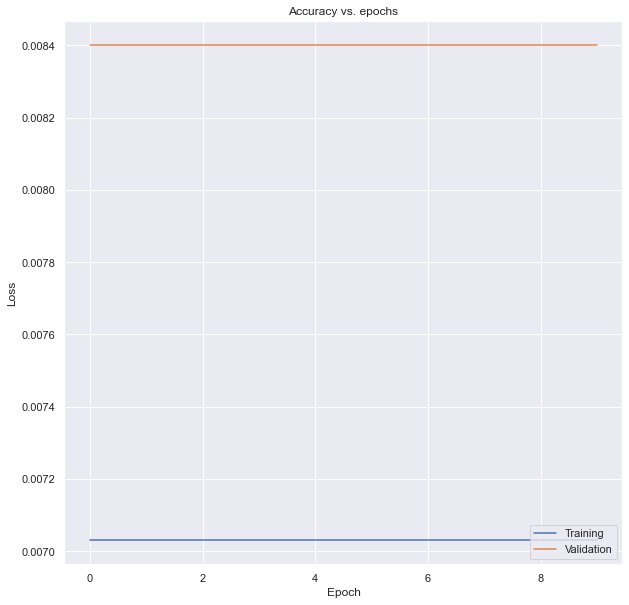

In [102]:
# Run this cell to plot the epoch vs accuracy graph

try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

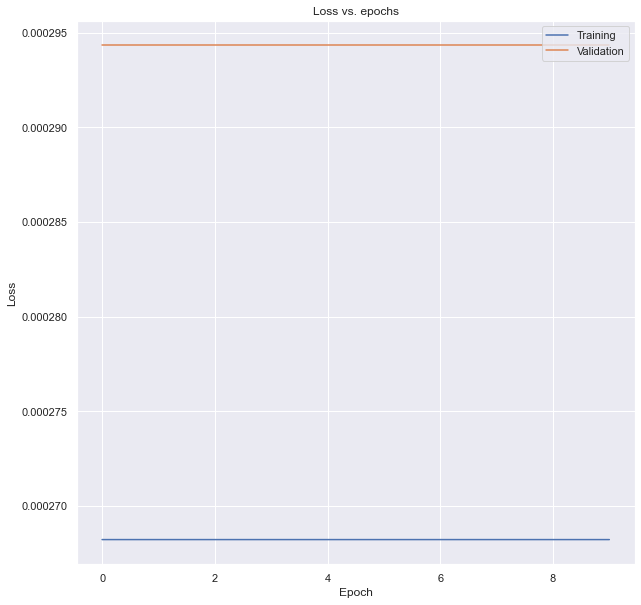

In [103]:
#Run this cell to plot the epoch vs loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

## Other

In [ ]:
# Get weather stations ordered by distance to Vancouver, BC
stations = Stations(lat = 38.843988, lon = -122.759707, daily = datetime(2018, 1, 1))
# Fetch closest station (limit = 1)
station = stations.fetch(1)

data = Daily(station, start = datetime(2018, 1, 1), end = datetime(2018, 1, 1))
# Fetch Pandas DataFrame
data = data.fetch()

data.plot(y=['tavg', 'tmin', 'tmax'])